# Example T20: W Brace with Reduced cross-section

This example shows the computation of the factored tension resistance of a W shape used as a tension
member in a lateral brace in a building such as that shown in the following photo.  There are 4 braces
shown.  Note that the upper left brace has the flange tips removed from the W-shape (to ensure 
ductility under seismic forces).  We will compute the strength of a brace similar to that shown
in the photo.

In [1]:
from Designer import DesignNotes, SST, makePart, show

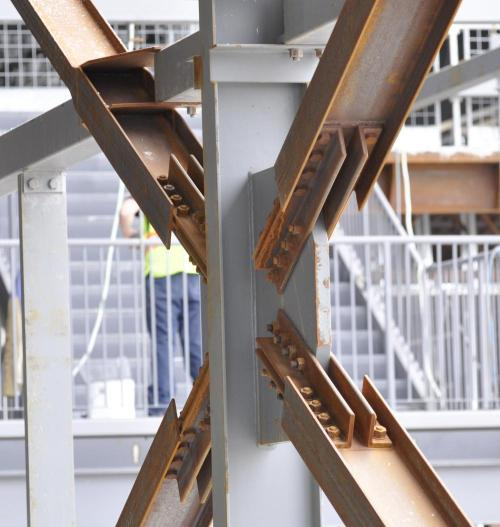

In [2]:
%figure "DSC6443-small.jpg"

#### Load and Setup the Library Modules

In [3]:
import pint                  # setup to use the module for computing with units
ureg = pint.UnitRegistry()
mm = ureg['mm']
inch = ureg['inch']
kN = ureg['kN']
MPa = ureg['MPa']
ureg.default_format = '~P'

In [4]:
notes = DesignNotes('Tr',trace=True,units=kN)      # initial the note/record keeping object
RECORD = notes.record     # useful abbreviations
CHECK = notes.check

## Problem Statement

Compute the factored tension resistance, $T_r$, of the following assembly.  Steel is G40.21 350W and bolts are 3/4" ASTM A325 in 22mm punched holes.

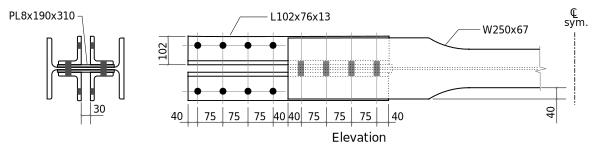

In [5]:
%figure "brace1.svg"

Note that 40mm is cut from each flange tip of the W250x67.

## Angles

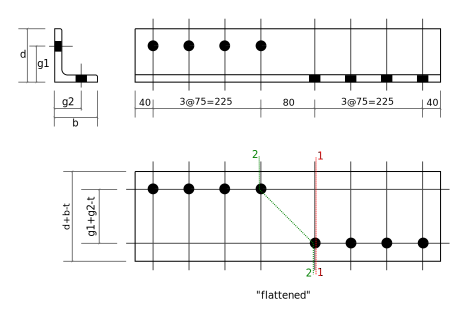

In [6]:
%figure "angle.svg"

In [7]:
@makePart
class Bolts:
    "Bolts"
    grade = 'ASTM A325'
    size = '3/4"'
    d = (3/4*inch).to(mm)
    Fu = 825*MPa
    Ab = 3.14159*d**2/4.
    n = 4                    # number of bolts per end
    s = 75.*mm                  # bolt spacing
    threads_intercepted = True

Bolts.show('grade,size,d,Fu,Ab,n,s')

grade = ASTM A325 
size  = 3/4"  
d     = 19.05 mm
Fu    = 825   MPa
Ab    = 285   mm²
n     = 4     
s     = 75    mm


In [8]:

@makePart
class Angles:
    "Angles"
    grade = 'CSA G40.21 350W'
    Fy = 350*MPa
    Fu = 450*MPa
    d,b,t,Ag,size = SST.section('L102x76x13','D,B,T,A,Dsg')
    d = d*mm
    b = b*mm
    t = t*mm
    Ag = Ag*mm*mm
    ha = (22 + 2)*mm  # hole allowance  - punched holes
    g1 = 65*mm        # gauge, longer leg
    g2 = 45*mm        # gauge, shorter leg
    s = 80*mm         # dist between innermost holes on each end

Angles.show('grade,Fy,Fu,size,d,b,t,Ag,g1,g2,s,ha')

grade = CSA G40.21 350W 
Fy    = 350  MPa
Fu    = 450  MPa
size  = L102x76x13 
d     = 102  mm
b     = 76.2 mm
t     = 12.7 mm
Ag    = 2100 mm²
g1    = 65   mm
g2    = 45   mm
s     = 80   mm
ha    = 24   mm


### Check Details (TO BE DONE!)
* Bolt spacings, edge distances
* Fit within flanges (need gusset thickness)

In [9]:
CHECK(False,'Bolting and fitting details have not been checked.')

    Bolting and fitting details have not been checked.?  NG! *****
      ()


### Net Section Fracture:

In [10]:
with Angles:
    # gross width = "flattened" width of angle:
    wg = d + b - t

    # failure path 1-1: 1 hole
    wn1 = wg - 1*ha

    # failure path 2-2: 2 holes
    g = g1 + g2 - t
    wn2 = wg - 2*ha + s**2/(4*g)

    wn = min(wn1,wn2)
    show('wg,g,s,wn1,wn2,wn')

wg  = 165.5 mm
g   = 97.3  mm
s   = 80    mm
wn1 = 141.5 mm
wn2 = 133.9 mm
wn  = 133.9 mm


In [11]:
with Angles,Bolts['n']:
    An = wn*t
    Ane = 0.8*An if n >= 4 else 0.6*An   # S16-14: 12.3.3.2 (b) (i) - connected 1 leg n lines of bolts
    phiu = 0.75
    Tr = 4. * phiu*Ane*Fu    # S16-14: 13.2 a) iii)
    RECORD(Tr,'Net section fracture, 4 angles','An,Ane,Tr,Fu,n');

    Net section fracture, 4 angles: Tr = 1837 kN
       (An=1701mm², Ane=1361mm², Fu=450MPa, n=4)

### Gross Section Yield:

In [12]:
with Angles:
    phi = 0.9
    Tr = 4. * phi*Ag*Fy    # S16-14: 13.2 a) i)
    RECORD(Tr,'Gross section yield, 4 angles','Ag,Fy,Tr');

    Gross section yield, 4 angles: Tr = 2646 kN
       (Ag=2100mm², Fy=350MPa)

### Block Shear

In [13]:
with Angles,Bolts['n,s']:
    Agv = (40*mm + (n-1)*s)*t
    An = (min(d-g1,b-g2) - ha/2.)*t
    Ut = 0.3     # SUPER conservative
    phiu = 0.75
    Tr = 4. * phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)
    RECORD(Tr,'Block shear, 4 angles','Ut,An,Agv,Tr');

    Block shear, 4 angles: Tr = 2522 kN
       (Ut=0.3, An=243.8mm², Agv=3366mm²)

## Tr for W Shape

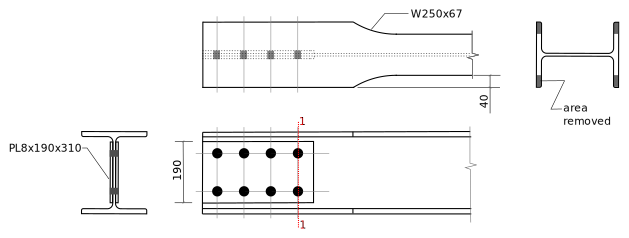

In [14]:
%figure "w.svg"

In [15]:
@makePart
class WShape:
    "WShape"
    grade = 'ASTM A992'
    Fy = 345*MPa
    Fu = 450*MPa
    Ag,b,d,t,w,size = SST.section('W250x67',properties='A,B,D,T,W,Dsg')
    Ag = Ag*mm*mm
    b = b*mm
    d = d*mm
    t = t*mm
    w = w*mm
    wp = 190*mm          # width of web reinforcing PL
    tp = 8*mm            # thickness of web reinforcing PL
    wc = 40*mm           # width cut from flange tips

WShape.show('grade,size,Fy,Fu,Ag,b,d,t,w,wp,tp,wc')

grade = ASTM A992 
size  = W250x67 
Fy    = 345  MPa
Fu    = 450  MPa
Ag    = 8550 mm²
b     = 204  mm
d     = 257  mm
t     = 15.7 mm
w     = 8.9  mm
wp    = 190  mm
tp    = 8    mm
wc    = 40   mm


### Net section fracture

In [16]:
# Path 1-1: net = gross  +  plates  -  holes
with Angles,WShape:
    An = Ag  +  2*tp*wp   -  2*ha*(w+tp+tp)
    Ane = 0.85*An    # S16-14: 12.3.3.2 (c) (i)
    phiu = 0.75
    Tr = phiu*Ane*Fu
    RECORD(Tr,'Net section fracture, W shape','Ag,ha,w,tp,An,Ane,Tr');

    Net section fracture, W shape: Tr = 2982 kN
       (Ag=8550mm², ha=24mm, w=8.9mm, tp=8mm, An=10390mm², Ane=8836mm²)

### Gross section yield

In [17]:
with WShape:
    Agr = Ag - 4*wc*t   # reduced area due to flange cuts
    phi = 0.9
    Tr = phi*Fy*Agr     # S16-14: 13.2 a) i)
    RECORD(Tr,'Gross section yield, W shape','Agr,Tr');

    Gross section yield, W shape: Tr = 1875 kN
       (Agr=6038mm²)

### Block Shear

In [18]:
with Angles,WShape,Bolts['n,s']:
    T = w + tp + tp          # thickness of web + reinforcing plates
    Agv = 2*(40*mm + (n-1)*s)*T
    An = (g2 + g2 + 25*mm - ha)*T   # estimate 25mm spacing between angles (gusset thickness)
    Ut = 1.0
    phiu = 0.75
    Tr = phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)       # S16-14: 13.11
    RECORD(Tr,'Block shear, W shape','T,Ut,An,Agv,Tr');

    Block shear, W shape: Tr = 3125 kN
       (T=24.9mm, Ut=1.0, An=2266mm², Agv=13200mm²)

### Tearout

In [19]:
with WShape,Bolts['n,s']:
    Agv = 4*(40*mm + (n-1)*s)*T
    An = 0*mm*mm
    Ut = 1.0
    phiu = 0.75
    Tr = phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)       # S16-14: 13.11
    RECORD(Tr,'Tearout, W shape','Ut,An,Agv,Tr');

    Tearout, W shape: Tr = 4721 kN
       (Ut=1.0, An=0mm², Agv=26390mm²)

### Bolt Shear

In [20]:
with Bolts:
    phib = 0.8
    m = 2
    Tr = 0.6*phib*n*m*Ab*Fu * 2   # S16 13.12.1.2.b)
    L = (n-1)*s   # length of connection
    if L >= 760*mm:
        Tr = Tr * (0.5/0.6)
    if threads_intercepted:
        Tr = Tr * 0.7
    RECORD(Tr,'Bolt Shear','Fu,n,m,L,threads_intercepted')

    Bolt Shear: Tr = 1264 kN    <<<--- GOVERNS
       (Fu=825MPa, n=4, m=2, L=225.0mm, threads_intercepted=True)

### Bolt Bearing

In [21]:
with Angles,Bolts['n,d']:
    phibr = 0.8
    Br = 3*phibr*n*(t*2)*d*Fu * 2
    RECORD(Br,'Bolt Bearing (on angles)','n,t,Fu')

    Bolt Bearing (on angles): Tr = 4181 kN
       (n=4, t=12.7mm, Fu=450MPa)

## Summary

In [22]:
notes.summary()


Summary of DesignNotes for Tr

Checks:
-------
    Bolting and fitting details have not been checked.?   NG! *****
      ()

Values of Tr:
-------------
    Net section fracture, 4 angles: Tr = 1840 kN
    Gross section yield, 4 angles:  Tr = 2650 kN
    Block shear, 4 angles:          Tr = 2520 kN
    Net section fracture, W shape:  Tr = 2980 kN
    Gross section yield, W shape:   Tr = 1870 kN
    Block shear, W shape:           Tr = 3130 kN
    Tearout, W shape:               Tr = 4720 kN
    Bolt Shear:                     Tr = 1260 kN    <<<--- GOVERNS
    Bolt Bearing (on angles):       Tr = 4180 kN

    Governing Value:
    ----------------
       Tr = 1260 kN


## To do:

- check bolt detailing
- check fit of angles between flanges
- bolts, bearing - gusset and web
- weld, reinforcing plates to web
- thickness of gusset plate. Bolts allow 100-45-45 = 10mm.  too little.

## Notes
* Note that gross section yield of the W should govern, but it does not, by a large margin.  
  - Obviously, more bolts are required, or detail them so that threads are not intercepted (risky
    for installation considerations).
  - Another thing to try would be slightly larger angles. Perhaps L127x76x13 (which would not require any       additional space between flanges).  
  - Or could shave a few more millimeters from flange tips.  
  - Of course, all this has to be compared with factored applied loads.